/tmp/ipykernel_71/2140673314.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


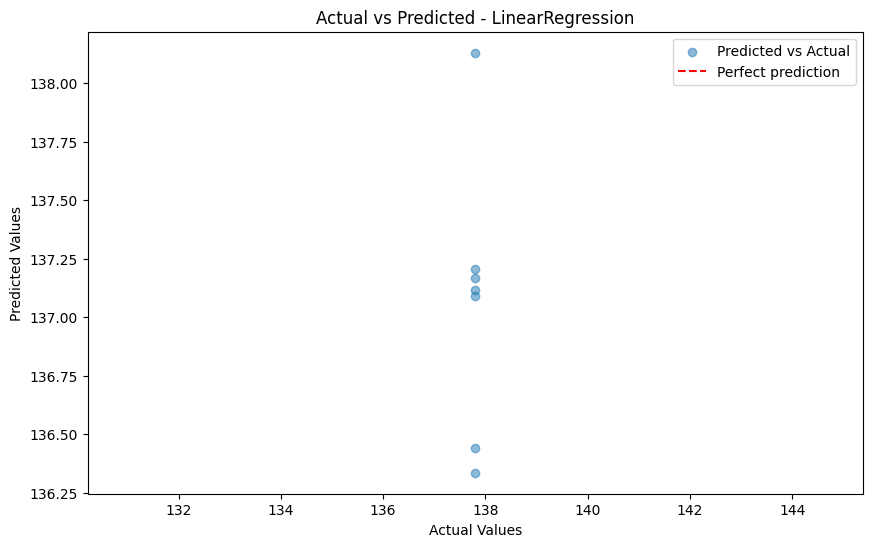

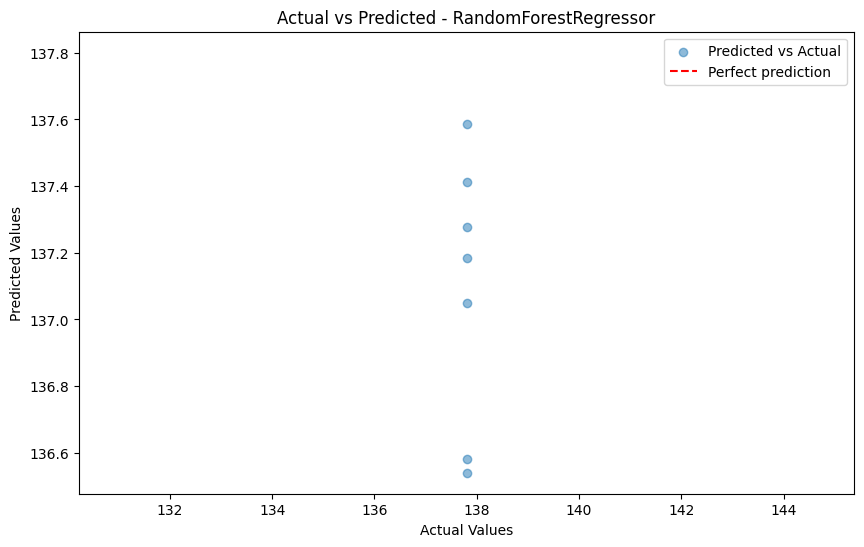

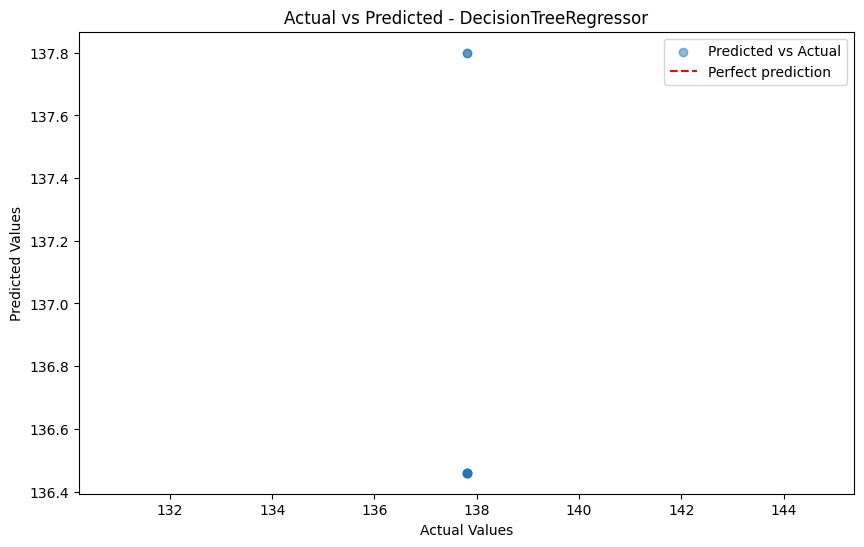

/opt/conda/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/py

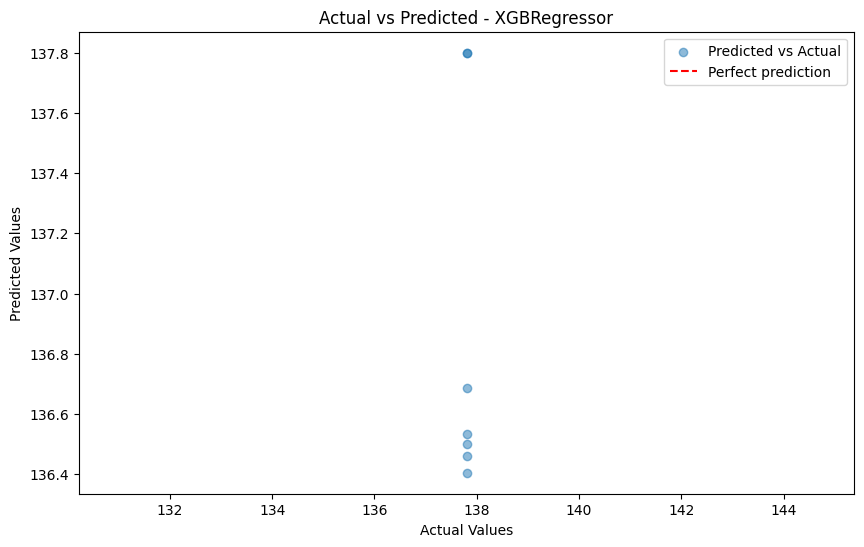

LinearRegression: RMSE = 0.9117
RandomForestRegressor: RMSE = 0.8006
DecisionTreeRegressor: RMSE = 1.1325
XGBRegressor: RMSE = 1.0880


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import psycopg2
from psycopg2.extras import execute_values
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Database connection function
def get_db_connection():
    """Create a connection to the PostgreSQL database"""
    return psycopg2.connect(
        host="aws-0-ap-southeast-1.pooler.supabase.com",
        database="postgres",
        user="postgres.nvssrkzspnbjzmhclcyf",
        password="kambing12345677778"
    )

# Retrieve and merge data
def get_merged_data():
    """Fetch merged data from the database"""
    conn = get_db_connection()
    query = """
        SELECT 
            w.date,
            c.rate,
            w.temperature_2m_mean,
            w.precipitation_sum,
            w.wind_speed_10m_max,
            w.weather_code
        FROM weather_data w
        LEFT JOIN (
            SELECT
                DATE_TRUNC('month', date) AS month,
                AVG(rate) AS rate
            FROM currency_data
            GROUP BY month
        ) c
        ON DATE_TRUNC('month', w.date) = c.month
        ORDER BY w.date
    """
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Load and preprocess data
df = get_merged_data()

# Drop rows with missing values
df.dropna(inplace=True)

# Prepare features and target
X = df.drop(['date', 'rate'], axis=1)  # Features
y = df['rate']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Model initialization
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor()
}

# Model training and evaluation
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = rmse
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.legend()
    plt.show()

# Display RMSE for each model
for model_name, rmse in results.items():
    print(f'{model_name}: RMSE = {rmse:.4f}')
